## Image Segmentation applied to real images

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.infer.mcmc import MCMC, HMC, NUTS, mcmc_kernel

from pyro.optim import Adam
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

assert pyro.__version__.startswith('1.8.1')
pyro.set_rng_seed(0)

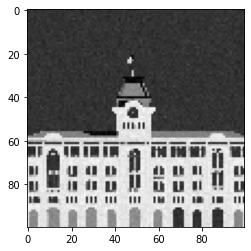

In [44]:
import cv2

img = plt.imread('img/piazzaunita.png')
plt.imshow(img)

# apply gaussian filter
data = (img[:,:,0])
filter = ndimage.gaussian_filter(data, sigma=0.2)

mask = (filter > filter.mean()).astype(np.float)
data = data*6 + 0.2*np.random.randn(*mask.shape)
data = cv2.resize(data, (100,100))


plt.imshow(data, cmap='gray')


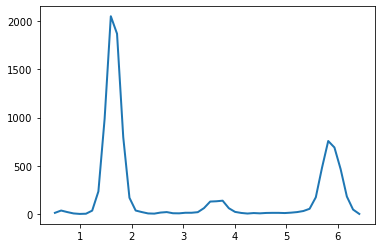

In [45]:
hist, bin_edges = np.histogram(data, bins=50)

bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
plt.plot(bin_centers, hist, lw=2)

In [7]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", Beta(1, alpha))

    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu", Normal(0., 5.))


    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(beta))) 
        pyro.sample("obs", Normal(mu[z], 1.), obs=data)

    return beta,mu,z



In [46]:
# set maximum number of clusters, alpha and size of observations
T = 6
alpha = 0.05

data = torch.reshape(torch.tensor(data), (-1,)).float()
N = data.shape[0]

### DO NOT run again if not needed!
Load dictionary containing results instead

In [87]:
# pyro.clear_param_store()
# nuts_kernel = NUTS(model)
# mcmc = MCMC(nuts_kernel, warmup_steps=200, num_samples=100, num_chains=1)
# mcmc.run(data=data)
# mcmc.summary()

Sample: 100%|██████████| 300/300 [14:48,  2.96s/it, step size=1.24e-01, acc. prob=0.833]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.32      0.00      0.32      0.31      0.32    194.80      1.01
   beta[1]      1.00      0.00      1.00      1.00      1.00    102.30      1.00
   beta[2]      0.89      0.22      1.00      0.53      1.00    101.13      0.99
   beta[3]      0.92      0.19      1.00      0.79      1.00     89.15      0.99
   beta[4]      0.89      0.23      1.00      0.49      1.00    145.30      0.99
   beta[5]      0.90      0.20      1.00      0.58      1.00    120.45      0.99
   beta[6]      0.93      0.15      0.99      0.76      1.00     86.05      0.99
     mu[0]      6.36      0.02      6.36      6.33      6.39    111.38      0.99
     mu[1]      1.98      0.01      1.98      1.96      1.99    175.31      0.99
     mu[2]      0.71      4.81      0.54     -6.39      9.08    239.16      0.99
     mu[3]     -0.57      5.10     -0.06     -8.24      7.35     53.18      1.03
     mu[4]      0.45      5

In [88]:
# mcmc_samples = mcmc.get_samples(group_by_chain=True)
# beta = mcmc_samples['beta'][0]
# mu = mcmc_samples['mu'][0]

In [32]:
import pickle

# the following three lines are to save results to file
# f = open("results/piazzaunita_mcmc_results.pkl", "wb")
# pickle.dump(mcmc_samples, f)
# f.close()

# the following is to load results from file
f = open("results/piazzaunita_mcmc_results.pkl", "rb")
output = pickle.load(f)
f.close()

# reassign mcmc_samples
mcmc_samples = output
beta = mcmc_samples['beta'][0]
mu = mcmc_samples['mu'][0]

In [47]:
from scipy.stats import norm 

w = mix_weights(beta)[-1]

n_samples = mu.shape[0]
n = data.shape[0]
cluster = np.zeros(n)

for i in range(n):
    q = torch.zeros(T)
    for j in range(T):
        q[j] = w[j]*norm.pdf(data[i], mu[-1][j], 1.) + q[j]

    cluster[i] = np.argmax(q)

(-0.5, 99.5, 99.5, -0.5)

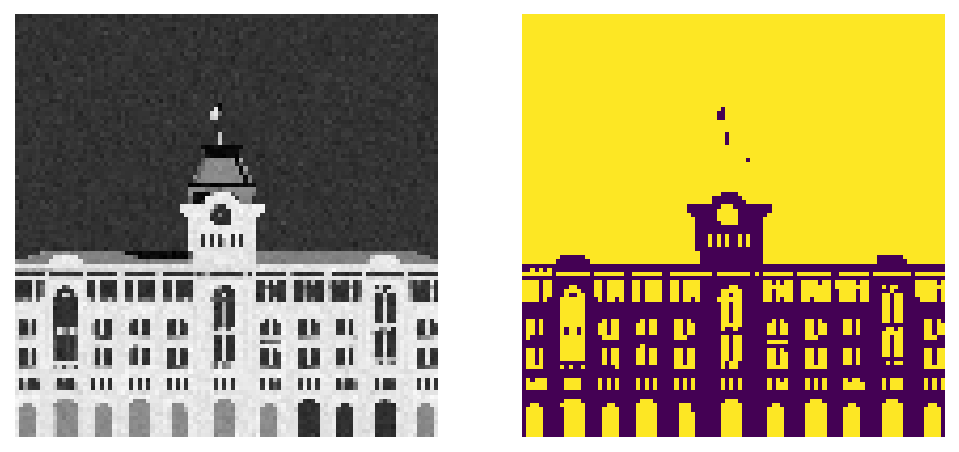

In [48]:
from matplotlib.pyplot import figure

fig = plt.figure(figsize=(8, 6), dpi=150)
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122) 

l1 = 100
l2 = 100

ax1.imshow(np.reshape(data, (l1,l2)), cmap='gray')
ax1.axis('off')

ax2.imshow( np.reshape(cluster, (l1,l2)))
ax2.axis('off')

#plt.savefig('segmente_img/piazza_unita.png', bbox_inches='tight')


In [34]:
print("number of clusters found: ", len(np.unique(cluster)))

number of clusters found:  2
